## <center> Advanced topics of regression </center>

For this chapter we will explore statsmodels OLS function, which gives a detailed description of an ordinary least square regression. Additional to that, a methodology to calculate and plot the confidence and prediction intervals will be presented.

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt    
from scipy import stats
import pandas as pd
import statsmodels.api as sm

import uncertainties.unumpy as unp
import uncertainties as unc

In [2]:
url = 'http://apmonitor.com/che263/uploads/Main/stats_data.txt'
data = pd.read_csv(url)
data.drop(columns="index", inplace=True)
x = data["x"]
y = data["y"]
n = data.shape[0]

### OLS
The output of linear regression models, can at first be daunting. Since understanding this type of output is a worthwhile step towards more complex models. For more information regarding the calculation of each parameter, see Ch.11 of book an Introduction to statistics with Python.

In [3]:
result = sm.OLS(y, x).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.753
Method:                 Least Squares   F-statistic:                              302.4
Date:                Wed, 14 Dec 2022   Prob (F-statistic):                    1.03e-31
Time:                        20:20:06   Log-Likelihood:                          116.15
No. Observations:                  99   AIC:                                     -230.3
Df Residuals:                      98   BIC:                                     -227.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Confidence and prediction intervals

In [4]:
# Curve fitting
def f(x, a, b):
    return a * x + b

params, pcov = curve_fit(f, x, y) # Parameters and covariance are computed

# Retrieve parameter values
a = params[0]
b = params[1]
print('Adjusted parameters')
print('a: ' + str(a))
print('b: ' + str(b))

Adjusted parameters
a: 0.036141582292222356
b: -0.5735680960487426


In [5]:
# Compute R^2
y_hat = f(x,*params)
SS_res = np.sum((y-y_hat)**2)

y_bar = np.mean(y)
SS_tot = np.sum((y-y_bar)**2)

r2 = 1 - SS_res/SS_tot
print('R^2: ' + str(r2))

R^2: 0.5278048667629538


#### Confidence interval
Defined by the formula:

$$ \hat{yy_i} \pm S_{\hat{yy_i}}*t_{n-n_{pms}, 1 - \frac{\alpha}{2}} $$

$$ S_{\hat{yy_i}} = \left( \frac{1}{n} + \frac{(xx_i - \bar{x})^2}{\sum^n _{i=1} (x_i - \bar{x})^2} \right)^{0.5} * \hat{\sigma}$$

It's important to mention the $yy$ and $xx$ values are vectors of new series of points. Also worth mention:
$$ \hat{\sigma}^2 = \frac{\sum^n _{i=1} y_i - \hat{y}_i}{n-n_{pms}}$$

In [6]:
px = np.linspace(14, 24, 100)

def conf_band(x, y, xx, pms, func, conf=0.95):
    n = x.size          # data sample size
    n_pms = len(pms)    # number of parameters
    alpha = 1.0 - conf  # significance

    # Quantile of Student's t distribution for p=(1-alpha/2)
    t_val = stats.t.ppf(1 - alpha/2, n-n_pms)

    # Standard deviation
    SSE = np.sum((y - func(x, *pms))**2)
    se = np.sqrt(SSE/(n - n_pms))

    # Sy
    upper = (xx - np.mean(x)) ** 2
    lower = np.sum((x - np.mean(x)) ** 2)
    Sy = np.sqrt(1/n + upper/lower)*se

    # Confidence band
    bnd = Sy*t_val

    yy = func(xx, *pms)

    # Upper & lower prediction bands.
    lcb, ucb = yy - bnd, yy + bnd
    return lcb, ucb

lcb, ucb = conf_band(x, y, px, params, f, conf=0.95)

#### Prediction interval
Defined by the formula:

$$ \hat{yy_i} \pm S_{\hat{yy_i}}*t_{n-n_{pms}, 1 - \frac{\alpha}{2}} $$

$$ S_{\hat{yy_i}} = \left( 1+  \frac{1}{n} + \frac{(xx_i - \bar{x})^2}{\sum^n _{i=1} (x_i - \bar{x})^2} \right)^{0.5} * \hat{\sigma}$$


In [7]:
def pred_band(x, y, xx, pms, func, conf=0.95):
    n = x.size          # data sample size
    n_pms = len(pms)    # number of parameters
    alpha = 1.0 - conf  # significance

    # Quantile of Student's t distribution for p=(1-alpha/2)
    t_val = stats.t.ppf(1 - alpha/2, n-n_pms)

    # Standard deviation
    SSE = np.sum((y - func(x, *pms))**2)
    se = np.sqrt(SSE/(n - n_pms))
    
    # Sy
    upper = (xx - np.mean(x)) ** 2
    lower = np.sum((x - np.mean(x)) ** 2)
    Sy = np.sqrt(1+ 1/n + upper/lower)*se

    # Confidence band
    bnd = Sy*t_val

    yy = func(xx, *pms)

    # Upper & lower prediction bands.
    lpb, upb = yy - bnd, yy + bnd
    return lpb, upb
lpb, upb = pred_band(x, y, px, params, f, conf=0.95)

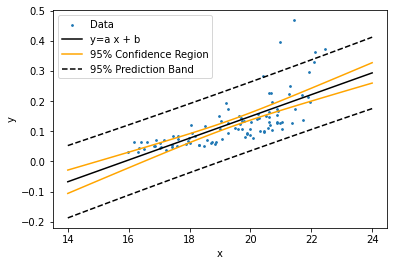

In [8]:
# plot the regression
plt.scatter(x, y, s=3, label='Data')
plt.plot(px, f(px, *params), c='black', label='y=a x + b')

# uncertainty lines (95% confidence)
plt.plot(px, lcb, c='orange',\
         label='95% Confidence Region')
plt.plot(px, ucb, c='orange')
# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')

# save and show figure
plt.show()

#### Non-linear approach

$$ y = a*e^{b*x+c} + d $$

In [9]:
# Curve fitting
def f(x, a, b, c, d):
    return a * np.exp(b*x + c) + d

params, pcov = curve_fit(f, x, y) # Parameters and covariance are computed

# Retrieve parameter values
a = params[0]
b = params[1]
c  = params[2]
d = params[3]
print('Adjusted parameters')
print('a: ' + str(a))
print('b: ' + str(b))
print('c: ' + str(c))
print('d: ' + str(d))

# Compute R^2
y_hat = f(x,*params)
SS_res = np.sum((y-y_hat)**2)

y_bar = np.mean(y)
SS_tot = np.sum((y-y_bar)**2)

r2 = 1 - SS_res/SS_tot
print('R^2: ' + str(r2))

Adjusted parameters
a: 1.4034117145227863e-05
b: 0.5282491576361579
c: -1.87851267816848
d: 0.04295811733021374
R^2: 0.6188720440602568


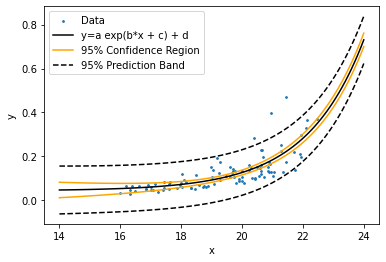

In [10]:
px = np.linspace(14, 24, 100)
lcb, ucb = conf_band(x, y, px, params, f, conf=0.95)
lpb, upb = pred_band(x, y, px, params, f, conf=0.95)

# plot the regression
plt.scatter(x, y, s=3, label='Data')
plt.plot(px, f(px, *params), c='black', label='y=a exp(b*x + c) + d')

# uncertainty lines (95% confidence)
plt.plot(px, lcb, c='orange',\
         label='95% Confidence Region')
plt.plot(px, ucb, c='orange')
# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')

# save and show figure
plt.show()